## Plot Taylor diagrams for pCO2 Residual Technique

In [35]:
import pandas as pd
import numpy as NP
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':600}
import matplotlib.pyplot as PLT

In [36]:
df = pd.read_csv(f'/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC_Taka/models/reconstructions/xg/ens_pCO2_Taylor_stats_1985-2018.csv')
df.columns

Index(['stats', 'pCO2-recon', 'observed', 'CSIR_ML6', 'JENA_MLS', 'JMA_MLR',
       'MPI_SOMFFN', 'NIES_FNN', 'CMEMS_FFNN', 'HPD'],
      dtype='object')

35.604917367387976


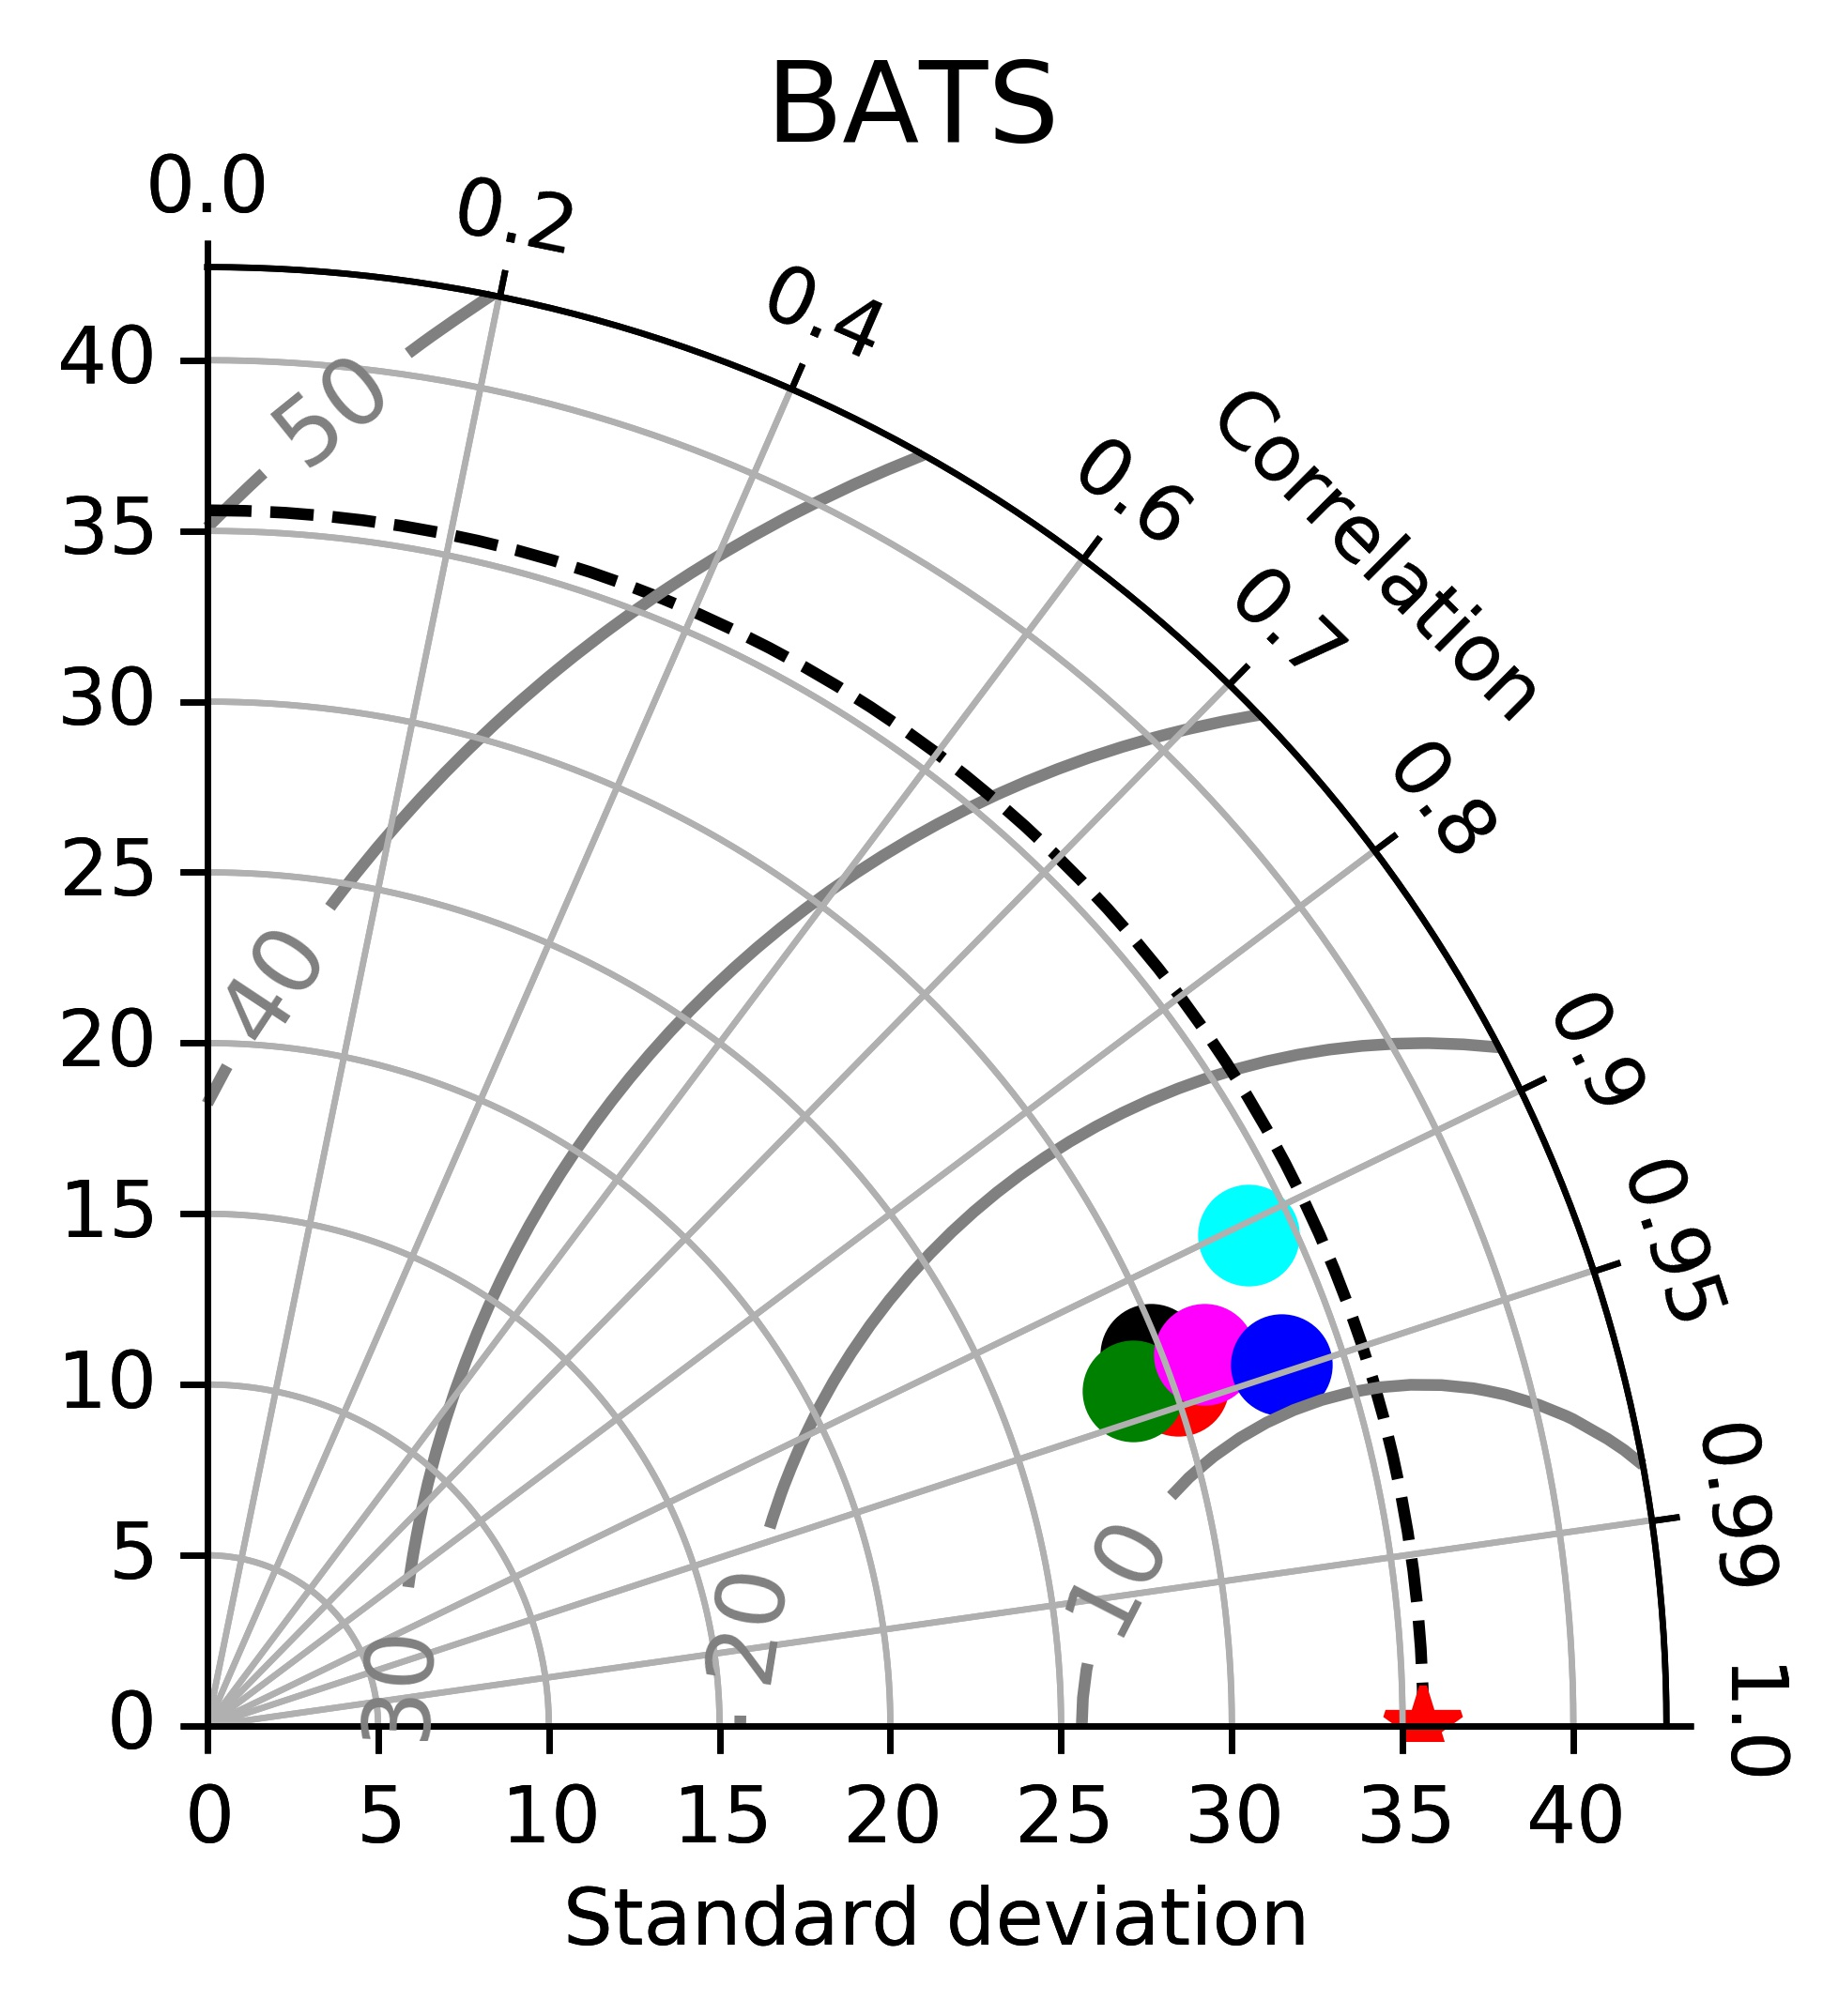

In [56]:
Taylor_locs(1985,2018,1)

19.401836934869273


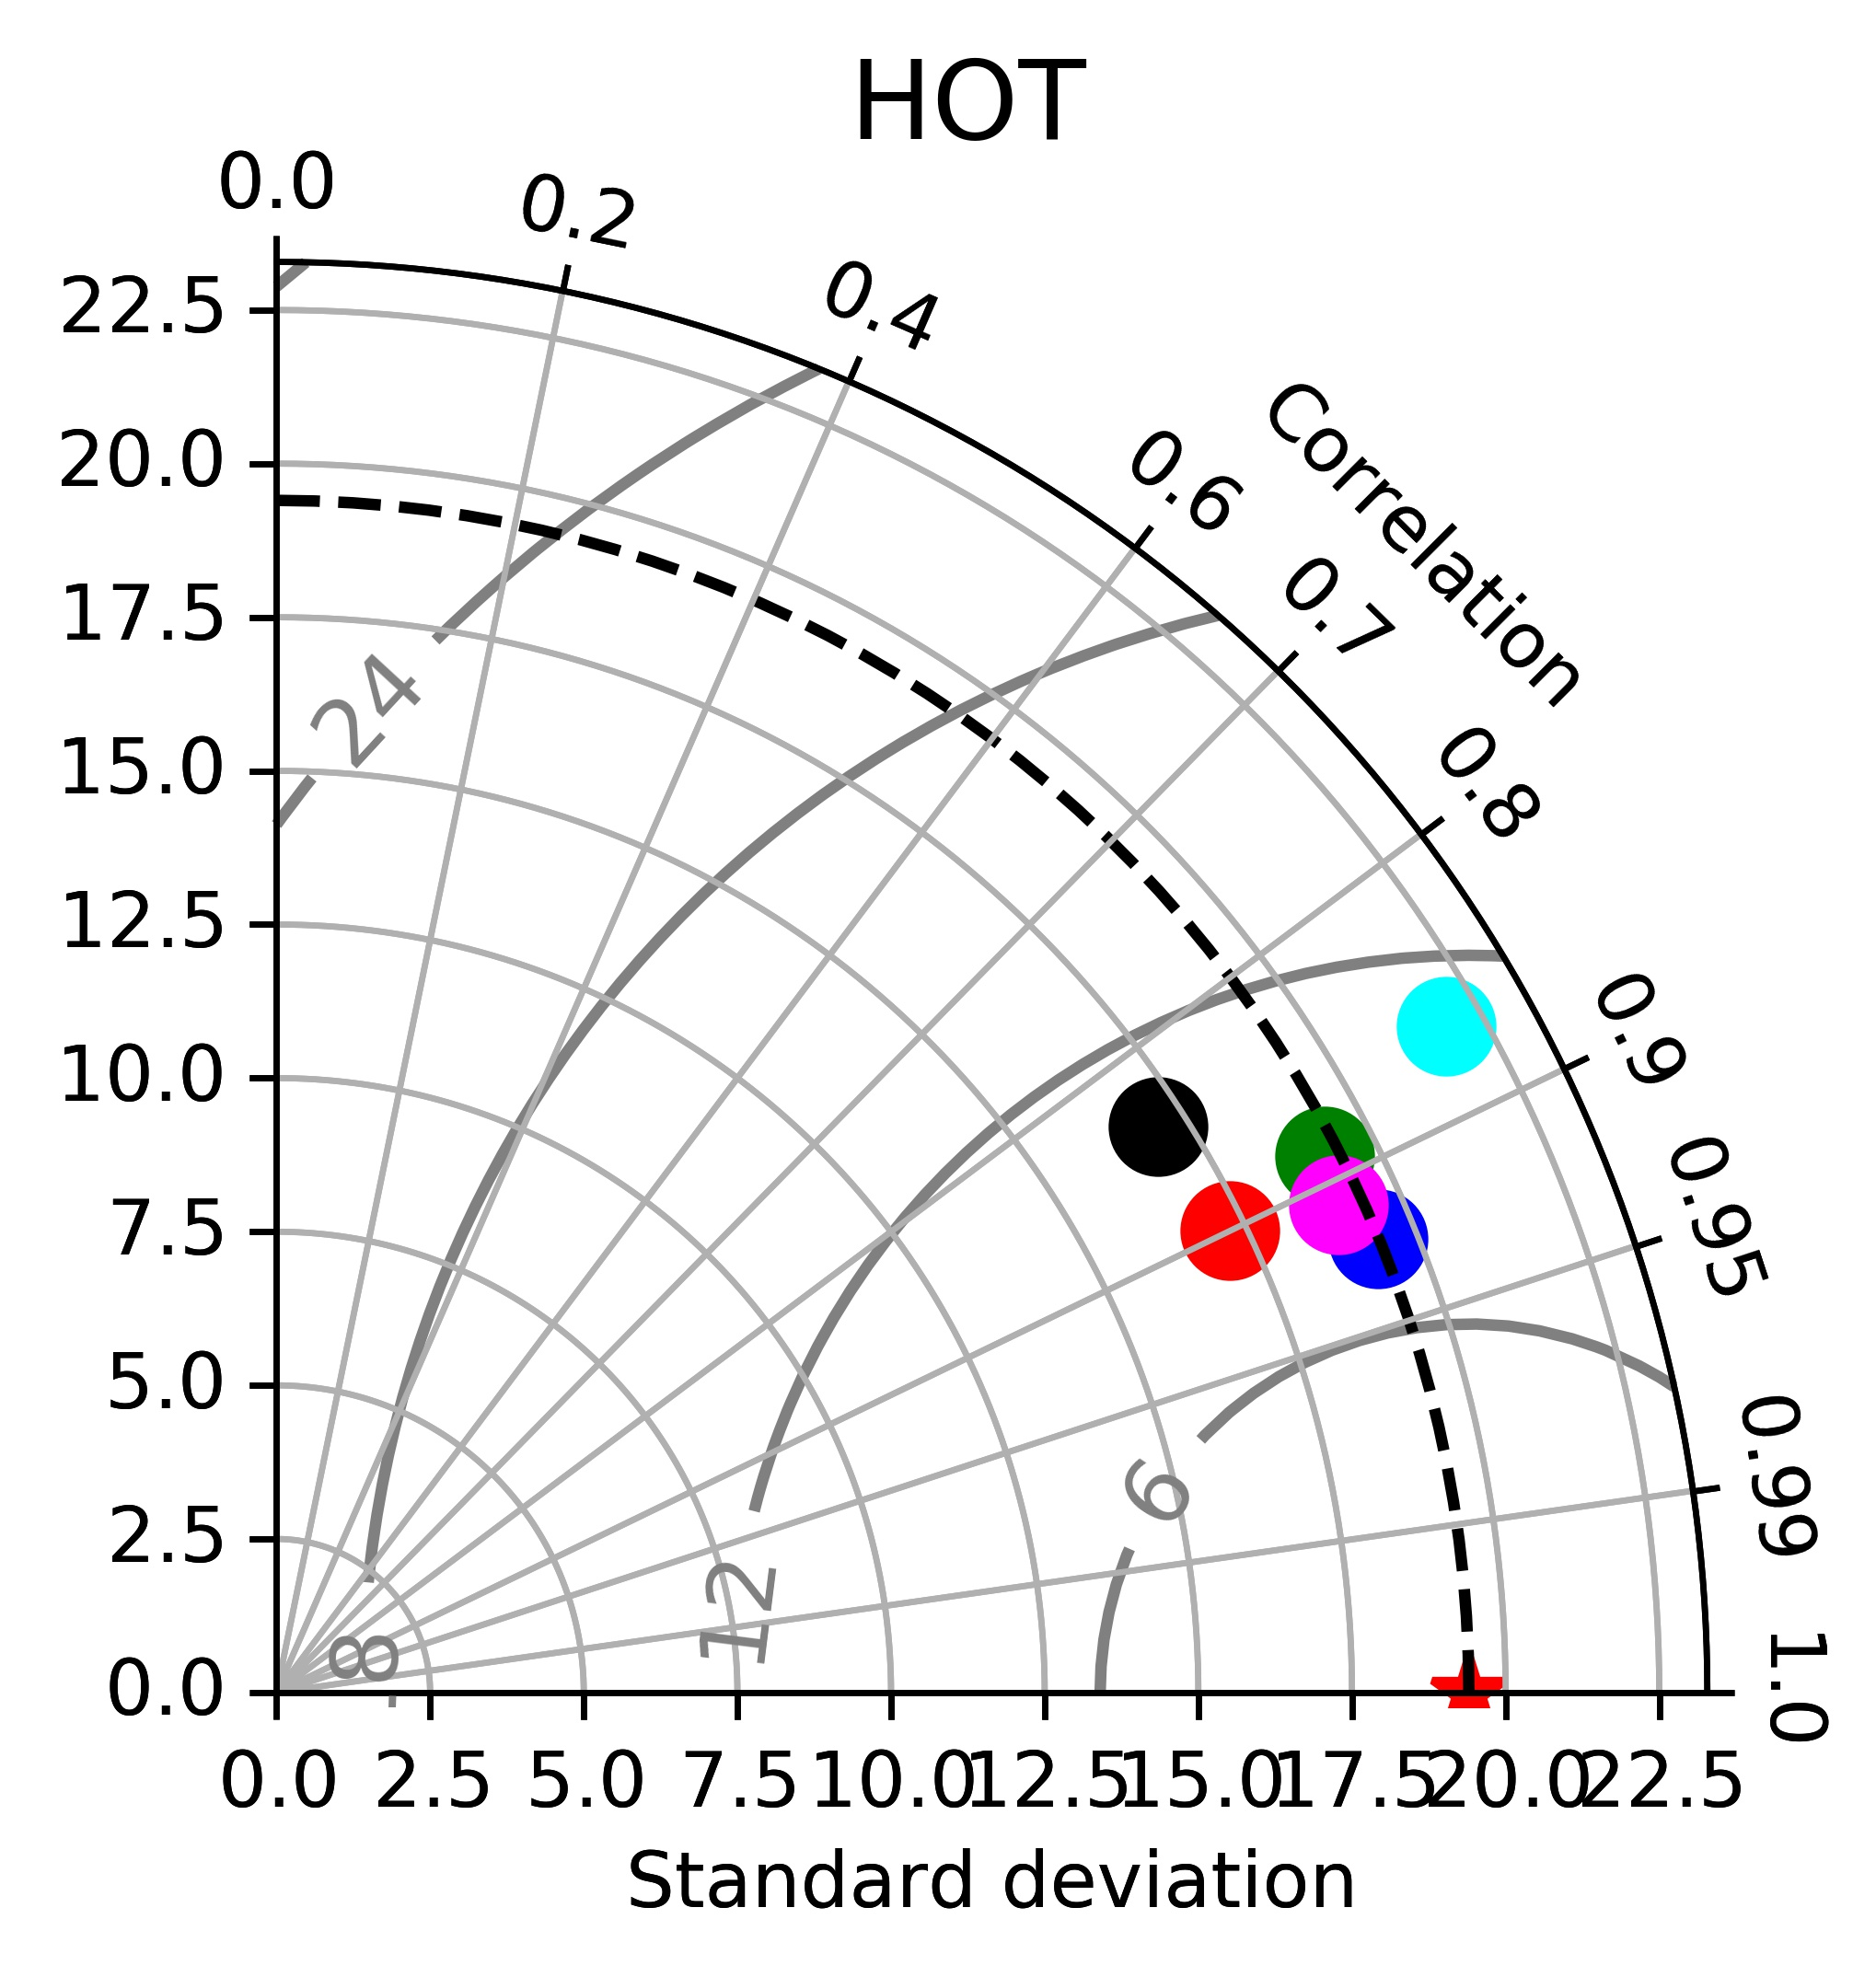

In [57]:
Taylor_locs(1985,2018,2)

36.73826201938137


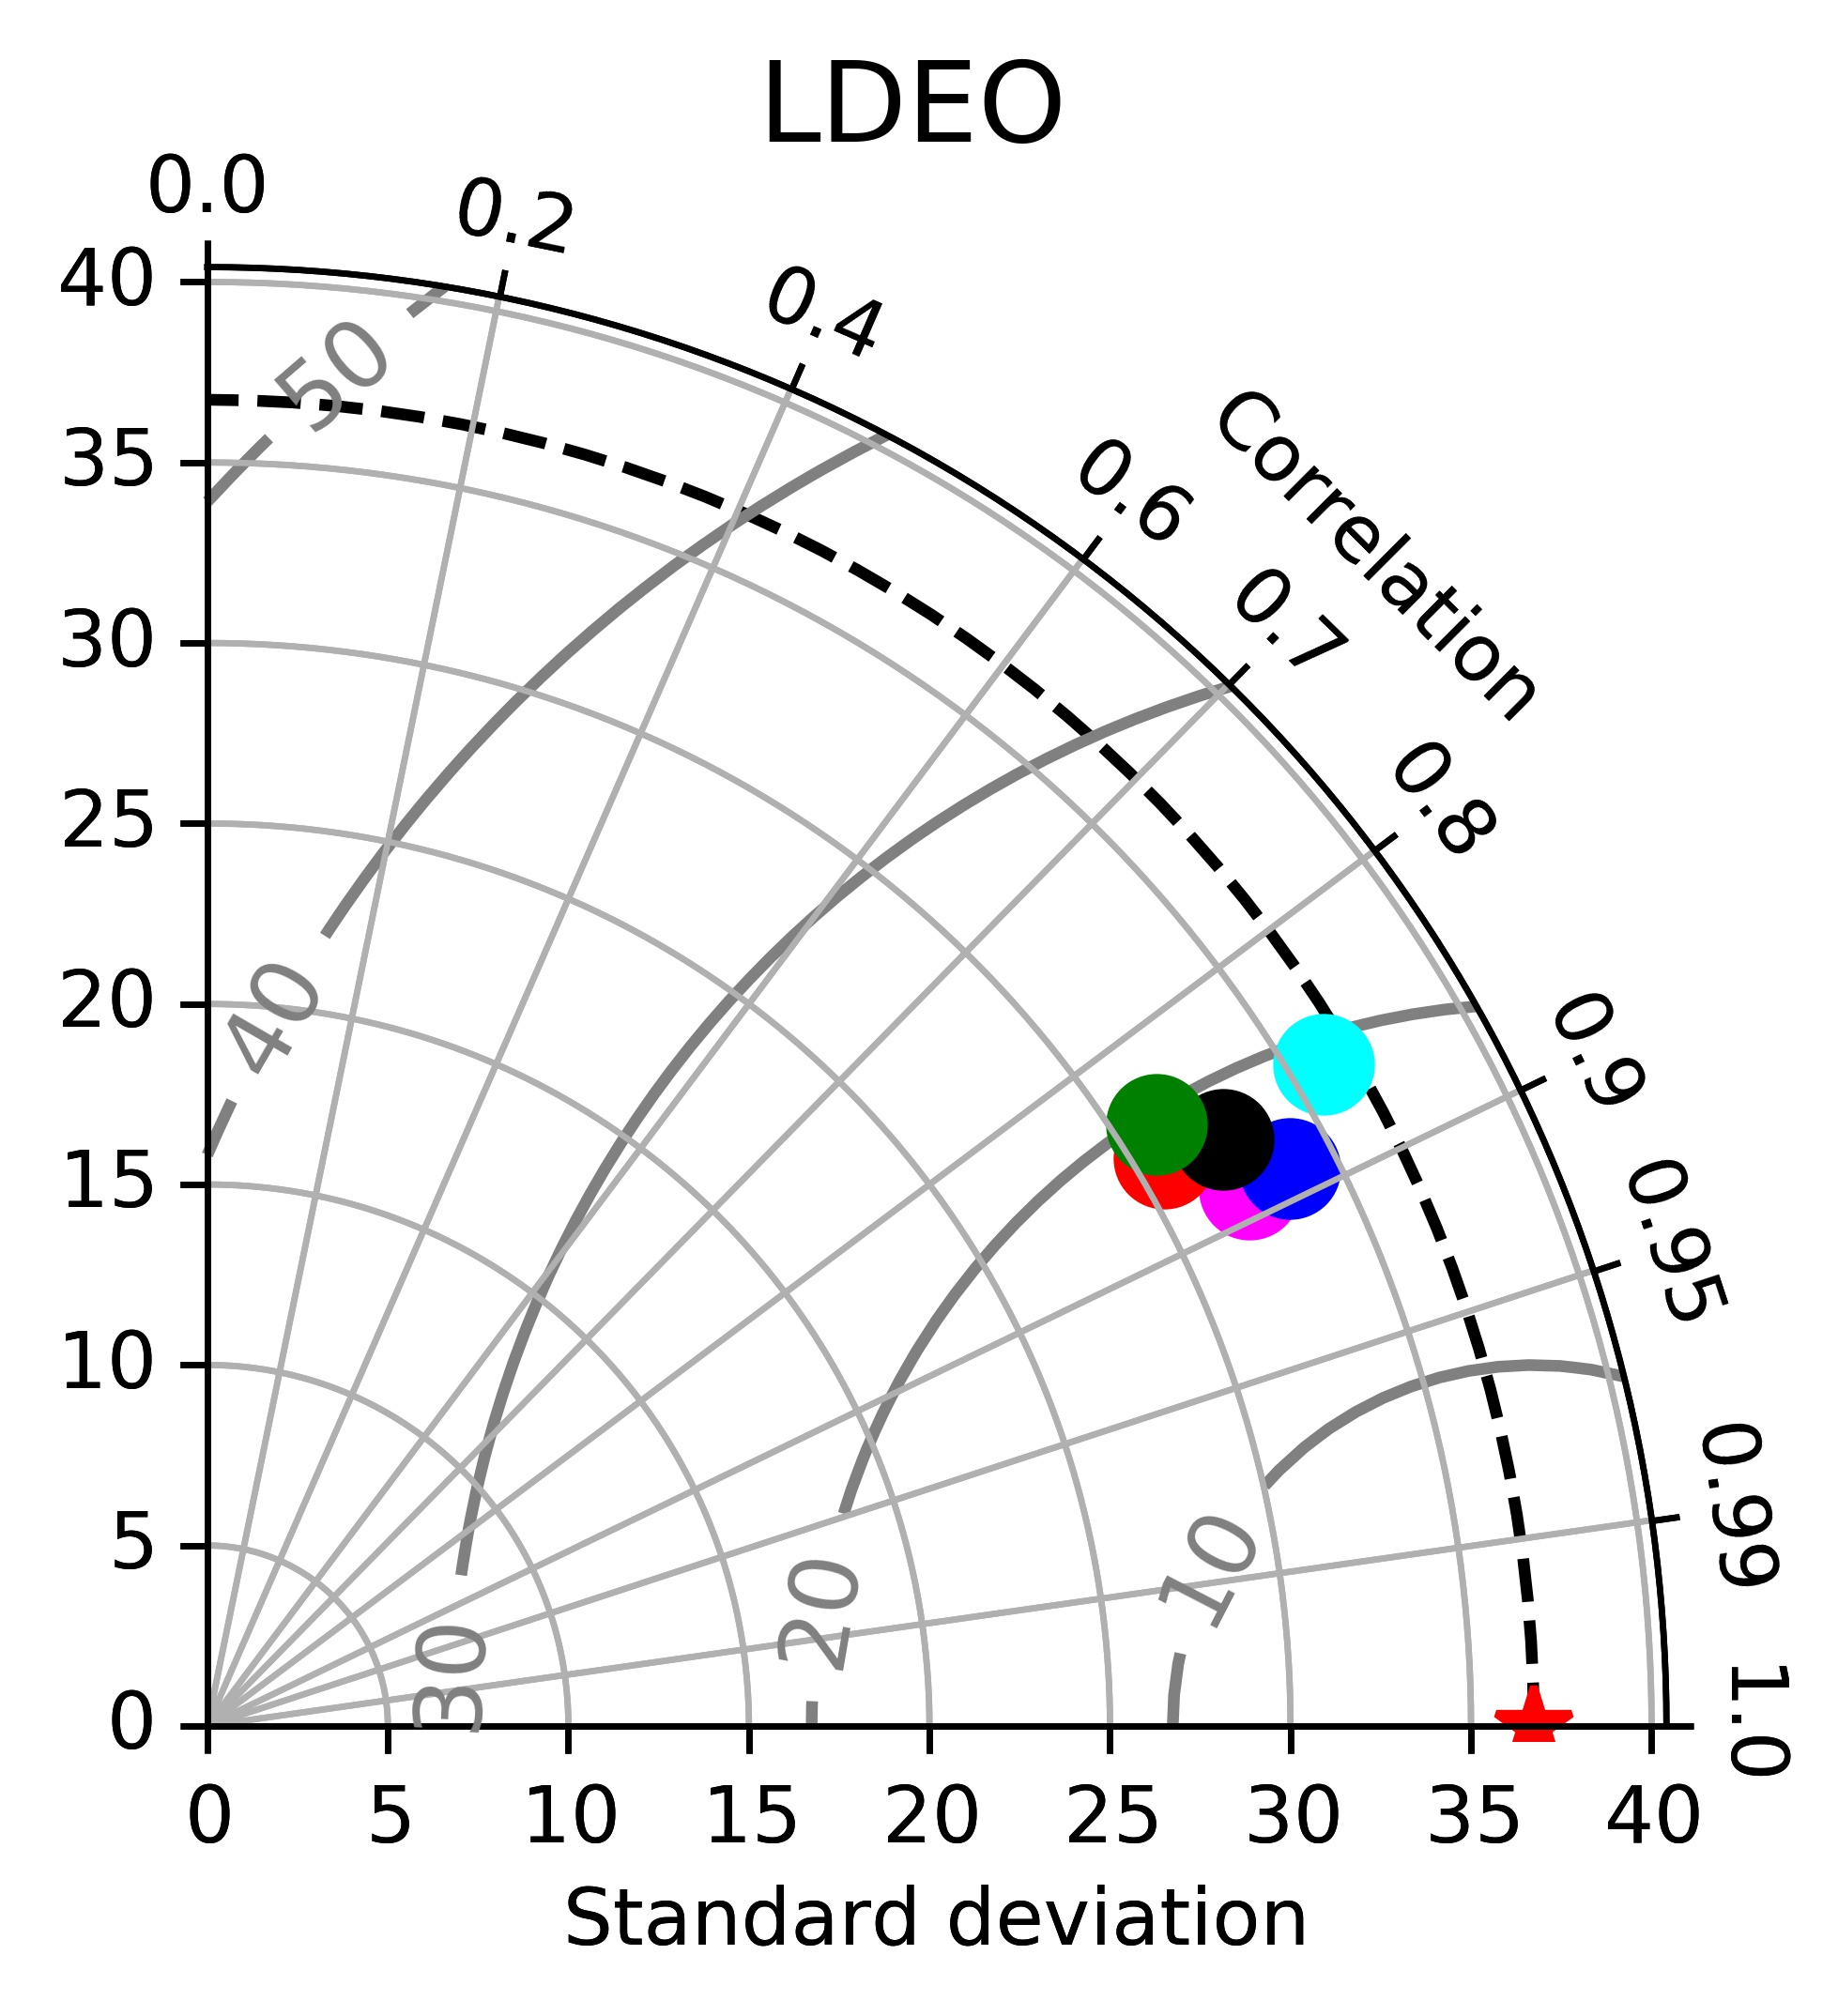

In [64]:
Taylor_locs(1985,2018,4,"LDEO_ens_Taylor_1985-2018.eps")

35.6549462876792


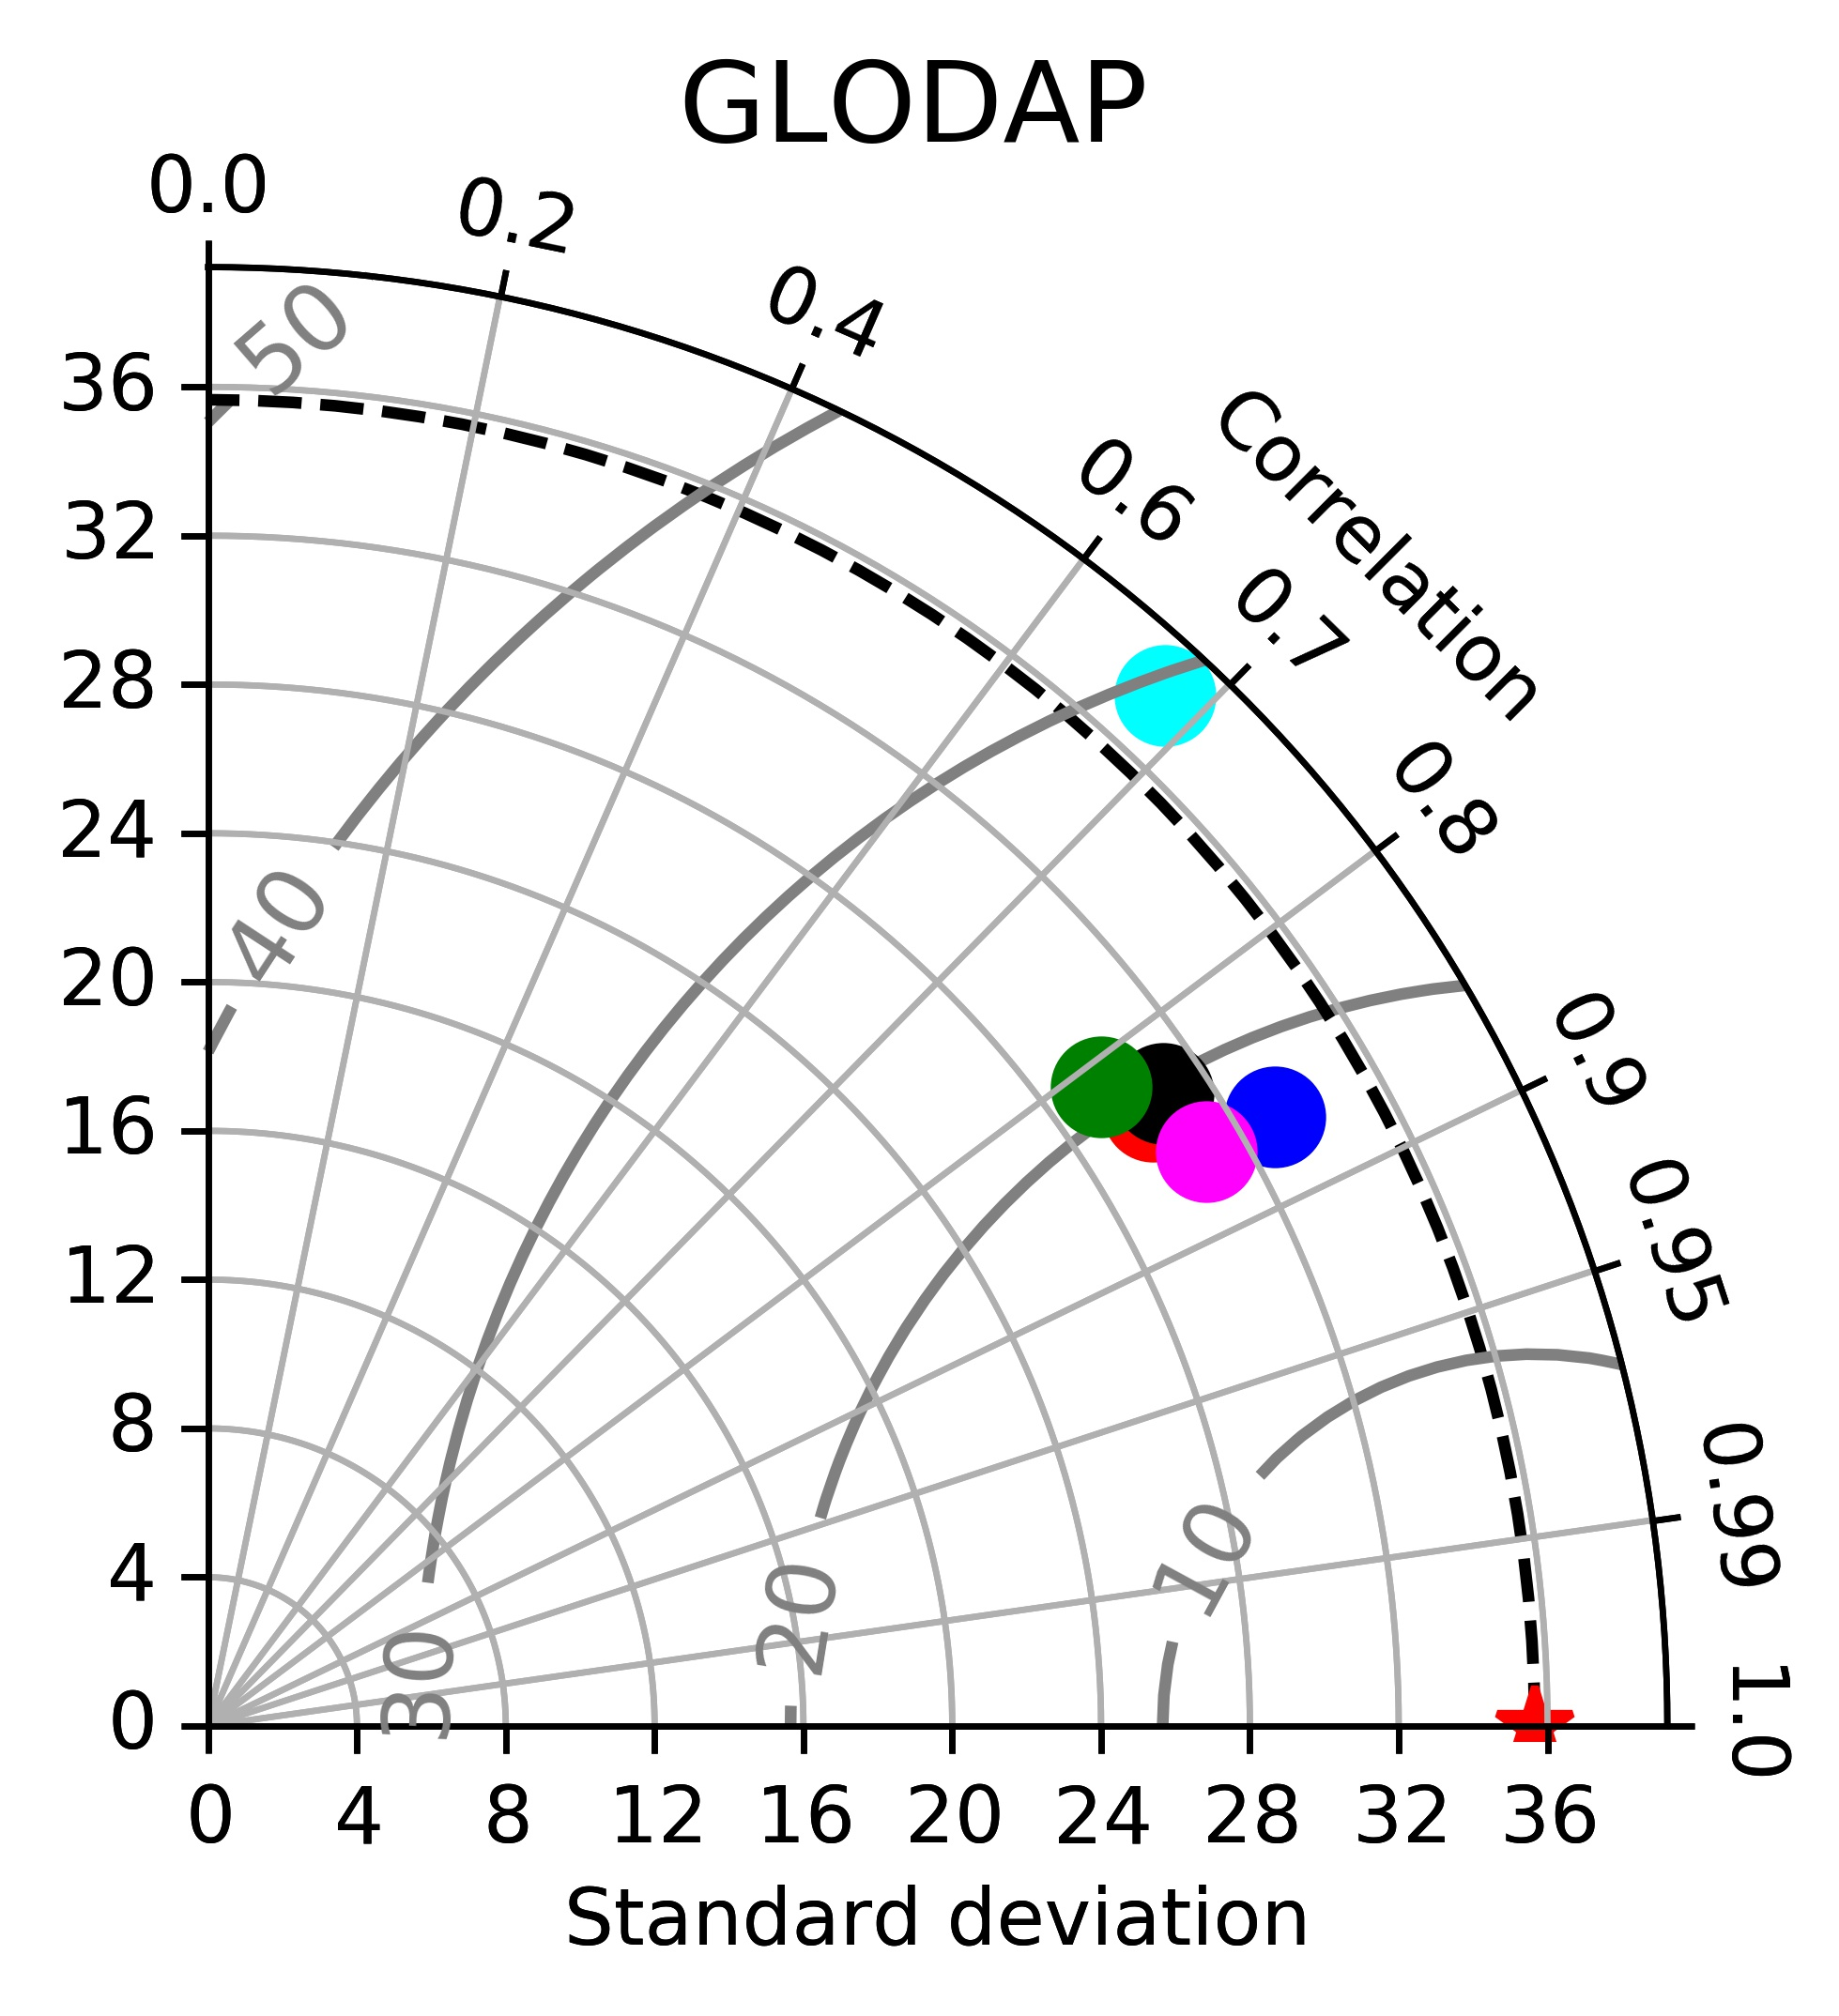

In [65]:
Taylor_locs(1985,2018,5,"GLODAP_ens_Taylor_1985-2018.eps")

In [37]:
def Taylor_locs(start_yr,end_yr,location,figname=None):
    
    df = pd.read_csv(f'/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC_Taka/models/reconstructions/xg/ens_pCO2_Taylor_stats_1985-2018.csv')
    variables = ['stats', 'pCO2-recon', 'observed', 'CSIR_ML6', 'JENA_MLS', 'JMA_MLR','MPI_SOMFFN', 'NIES_FNN', 'CMEMS_FFNN', 'HPD']
    if location == 1:   # BATS
        rowstd = 1
        rowr = 0
        labelt= "BATS"
    if location == 2:   # HOT
        rowstd = 4
        rowr = 3
        labelt = "HOT"
    if location == 3:    #SOCCOM
        rowstd = 7
        rowr = 6
        labelt = "SOCCOM"
    if location == 4:    # LDEO
        rowstd = 10
        rowr = 9
        labelt = "LDEO"
    if location == 5:   # GLODAP
        rowstd = 13
        rowr = 12
        labelt = "GLODAP"
    
    # Reference std
    stdref = df.iloc[rowstd,2] # grab correct row / column
    print(stdref)
    
    # Samples std,rho,name
    samples = [[df.iloc[rowstd,9], df.iloc[rowr,9], "HPD", "blue"],
               [df.iloc[rowstd,3], df.iloc[rowr,3], "CSIR_ML6", "red"],
               [df.iloc[rowstd,4], df.iloc[rowr,4], "JENA_MLS", "cyan"],
               [df.iloc[rowstd,6], df.iloc[rowr,6], "MPI_SOMFFN", "black"],
               [df.iloc[rowstd,8], df.iloc[rowr,8], "CMEMS_FFNN", "green"],
               [df.iloc[rowstd,1], df.iloc[rowr,1], "Residual", "magenta"],
              ]
    

    fig = PLT.figure(figsize=(3.5,3.5))

    dia = TaylorDiagram(stdref, fig=fig, label='Observed', extend=False)
    dia.samplePoints[0].set_color('r')  # Mark reference point as a red star

    # Add models to Taylor diagram
    for i, (stddev, corrcoef, name, colors) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       #marker='$%d$' % (i+1), ms=10, ls='',
                       marker='o', ms=12, ls='',
                       mfc=colors, mec=colors, color=colors,
                       label=name)

    # Add RMS contours, and label them
    contours = dia.add_contours(levels=5, colors='0.5')  # 5 levels in grey
    PLT.clabel(contours, inline=1, fontsize=12, fmt='%.0f')

    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add a figure legend and title
    #fig.legend(dia.samplePoints,
    #           [ p.get_label() for p in dia.samplePoints ],
    #           numpoints=1, prop=dict(size='medium'), loc='upper right')
    fig.suptitle(labelt, size='x-large')  # Figure title
    
    if figname!=None:
        fig.savefig(f'/home/vbennington/pCO2_Residual/{figname}',format='eps',dpi=1200)
    PLT.show()
    
    return dia

In [61]:
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.1), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.
        Parameters:
        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
        
        
    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l
        
    def add_grid(self, *args, **kwargs):
        """Add a grid."""
        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours         